In [51]:
import numpy as np    
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

In [52]:
data = pd.read_csv("kcd.csv") 

In [53]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Bp      400 non-null    float64
 1   Sg      400 non-null    float64
 2   Al      400 non-null    float64
 3   Su      400 non-null    float64
 4   Rbc     400 non-null    float64
 5   Bu      400 non-null    float64
 6   Sc      400 non-null    float64
 7   Sod     400 non-null    float64
 8   Pot     400 non-null    float64
 9   Hemo    400 non-null    float64
 10  Wbcc    400 non-null    float64
 11  Rbcc    400 non-null    float64
 12  Htn     400 non-null    float64
 13  Class   400 non-null    int64  
dtypes: float64(13), int64(1)
memory usage: 43.9 KB


Bp       0
Sg       0
Al       0
Su       0
Rbc      0
Bu       0
Sc       0
Sod      0
Pot      0
Hemo     0
Wbcc     0
Rbcc     0
Htn      0
Class    0
dtype: int64

# EDA

In [54]:
data.describe()

,Bp,Sg,Al,Su,Rbc,Bu,Sc,Sod,Pot,Hemo,Wbcc,Rbcc,Htn,Class
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.00000,400.00000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,76.455000,1.017712,1.015000,0.395000,0.882500,57.40550,3.07235,137.529025,4.627850,12.526900,8406.090000,4.708275,0.369350,0.625000
std,13.476536,0.005434,1.272329,1.040038,0.322418,49.28597,5.61749,9.204273,2.819783,2.716171,2523.219976,0.840315,0.482023,0.484729
min,50.000000,1.005000,0.000000,0.000000,0.000000,1.50000,0.40000,4.500000,2.500000,3.100000,2200.000000,2.100000,0.000000,0.000000
25%,70.000000,1.015000,0.000000,0.000000,1.000000,27.00000,0.90000,135.000000,4.000000,10.875000,6975.000000,4.500000,0.000000,0.000000
50%,78.000000,1.020000,1.000000,0.000000,1.000000,44.00000,1.40000,137.530000,4.630000,12.530000,8406.000000,4.710000,0.000000,1.000000
75%,80.000000,1.020000,2.000000,0.000000,1.000000,61.75000,3.07000,141.000000,4.800000,14.625000,9400.000000,5.100000,1.000000,1.000000
max,180.000000,1.025000,5.000000,5.000000,1.000000,391.00000,76.00000,163.000000,47.000000,17.800000,26400.000000,8.000000,1.000000,1.000000


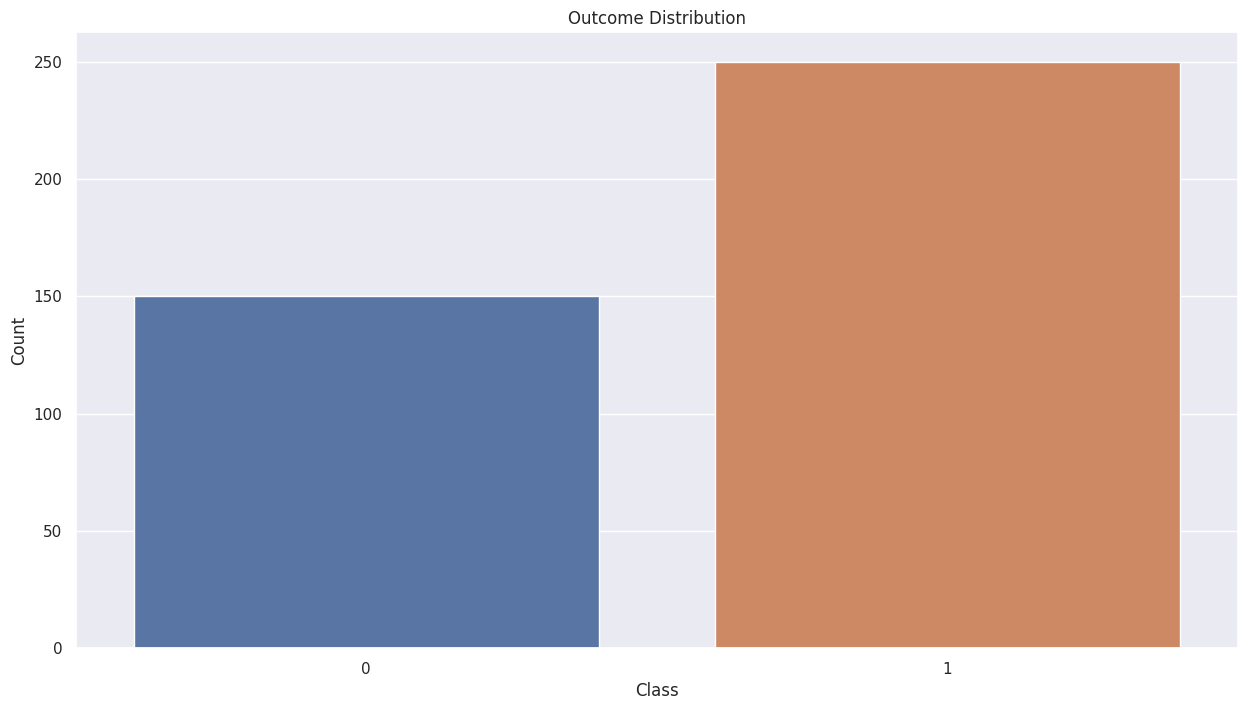

In [55]:
fig1, axes = plt.subplots(1,1)
plt.title('Outcome Distribution')
sns.barplot(x=data['Class'].unique(), y=data['Class'].value_counts(), data=data)
plt.xticks([0,1])
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()


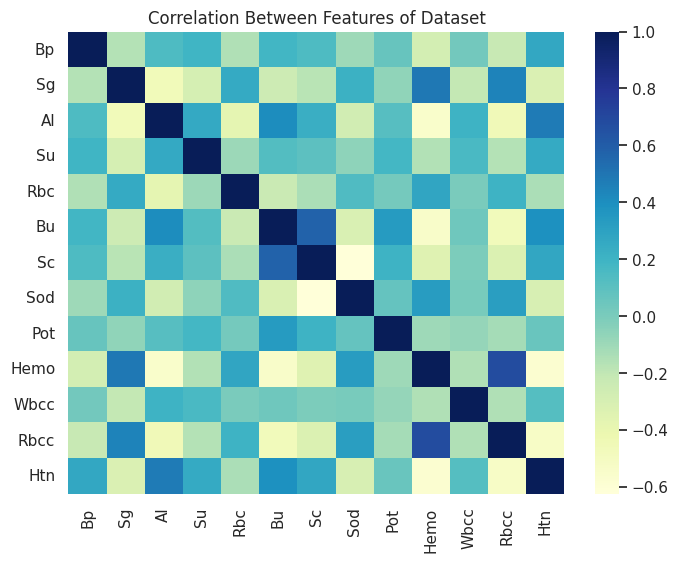

In [56]:
fig3, axes = plt.subplots(1,1,figsize=(8,6))
plt.title('Correlation Between Features of Dataset')
sns.heatmap(data.drop(columns = ['Class']).corr(), cmap="YlGnBu")
plt.show()

From the plots, we do not have much high correlation between features. I will use the independet variable, X to represent all features from our dataset

# Data Pre Processing and Feature Selection

In [57]:
f_values={}
for i in data.columns:
    count=data[i].nunique()
    if count==1:
        f_values[i]=count
# columns having same 1 unique value        
cols_drop= list(f_values.keys())
print('Columns to drop are:',cols_drop)

Columns to drop are: []


Our data reports 14 features (including 'Class') and 400 roles, no null values, no columns with 0 variance, 13 float dtypes and 'Class', a categorical dtype where 1 is mapped to Chronic Kidney Disease, 0 to not having Chronic Kidney Disease.



In [58]:
data = data.drop(['Su', 'Rbc'],axis=1)
data

,Bp,Sg,Al,Bu,Sc,Sod,Pot,Hemo,Wbcc,Rbcc,Htn,Class
0,80.0,1.020,1.0,36.0,1.2,137.53,4.63,15.4,7800.0,5.20,1.0,1
1,50.0,1.020,4.0,18.0,0.8,137.53,4.63,11.3,6000.0,4.71,0.0,1
2,80.0,1.010,2.0,53.0,1.8,137.53,4.63,9.6,7500.0,4.71,0.0,1
3,70.0,1.005,4.0,56.0,3.8,111.00,2.50,11.2,6700.0,3.90,1.0,1
4,80.0,1.010,2.0,26.0,1.4,137.53,4.63,11.6,7300.0,4.60,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
395,80.0,1.020,0.0,49.0,0.5,150.00,4.90,15.7,6700.0,4.90,0.0,0
396,70.0,1.025,0.0,31.0,1.2,141.00,3.50,16.5,7800.0,6.20,0.0,0
397,80.0,1.020,0.0,26.0,0.6,137.00,4.40,15.8,6600.0,5.40,0.0,0
398,60.0,1.025,0.0,50.0,1.0,135.00,4.90,14.2,7200.0,5.90,0.0,0


In [59]:
from sklearn.model_selection import train_test_split
features = data.drop(data.columns[-1],axis=1)
X = np.asarray(features)
y = data['Class']
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (320, 11)
y_train shape:  (320,)
X_test shape:  (80, 11)
y_test shape:  (80,)


# Logistic Regression

In [60]:
from sklearn.linear_model import LogisticRegression
model1 = LogisticRegression(max_iter=500)
model1.fit(X_train,y_train)
print('Training accuracy : ',model.score(X_train,y_train))
print('Test accuracy : ',model.score(X_test,y_test))

Training accuracy :  0.959375
Test accuracy :  0.9625


In [61]:
y_pred=model.predict(X_test)
y_pred

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0])

In [62]:
print(classification_report(y_test,y_pred))


              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.96      0.98      0.97        52

    accuracy                           0.96        80
   macro avg       0.96      0.95      0.96        80
weighted avg       0.96      0.96      0.96        80



# Random Forest Classifier

In [63]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)
model2.score(X_test,y_test)
print('Training accuracy : ',model2.score(X_test,y_test))

Training accuracy :  0.9875


In [64]:
y_prediction=model.predict(X_test)
y_prediction

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0])

In [65]:
print(classification_report(y_test,y_prediction))


              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.96      0.98      0.97        52

    accuracy                           0.96        80
   macro avg       0.96      0.95      0.96        80
weighted avg       0.96      0.96      0.96        80



# SVC

In [66]:
model3 = SVC(kernel='linear')
model3.fit(X_train, y_train)
print('Training accuracy : ', model3.score(X_train, y_train))
print('Test accuracy : ', model3.score(X_test,y_test))

Training accuracy :  0.971875
Test accuracy :  0.9625


In [67]:
y_prediction = model3.predict(X_test)
y_prediction

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0])

In [68]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.96      0.93      0.95        28
           1       0.96      0.98      0.97        52

    accuracy                           0.96        80
   macro avg       0.96      0.95      0.96        80
weighted avg       0.96      0.96      0.96        80



# KNeighborsClassifier

In [69]:
model4 = KNeighborsClassifier()
model4.fit(X_train, y_train)
print('Training accuracy : ', model4.score(X_train, y_train))
print('Test accuracy : ', model4.score(X_test,y_test))

Training accuracy :  0.778125
Test accuracy :  0.725


In [70]:
y_prediction = model4.predict(X_test)
y_prediction

array([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0])

In [71]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.57      0.86      0.69        28
           1       0.89      0.65      0.76        52

    accuracy                           0.73        80
   macro avg       0.73      0.76      0.72        80
weighted avg       0.78      0.72      0.73        80



# XGBoost

In [72]:
model5 = xgb.XGBClassifier()
model5.fit(X_train, y_train)
print('Training accuracy:', model5.score(X_train, y_train))
print('Test accuracy:', model5.score(X_test, y_test))

Training accuracy: 1.0
Test accuracy: 0.9875


In [73]:
y_prediction = model5.predict(X_test)
y_prediction

array([1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0])

In [74]:
print(classification_report(y_test, y_prediction))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        28
           1       1.00      0.98      0.99        52

    accuracy                           0.99        80
   macro avg       0.98      0.99      0.99        80
weighted avg       0.99      0.99      0.99        80



# Model Comparison

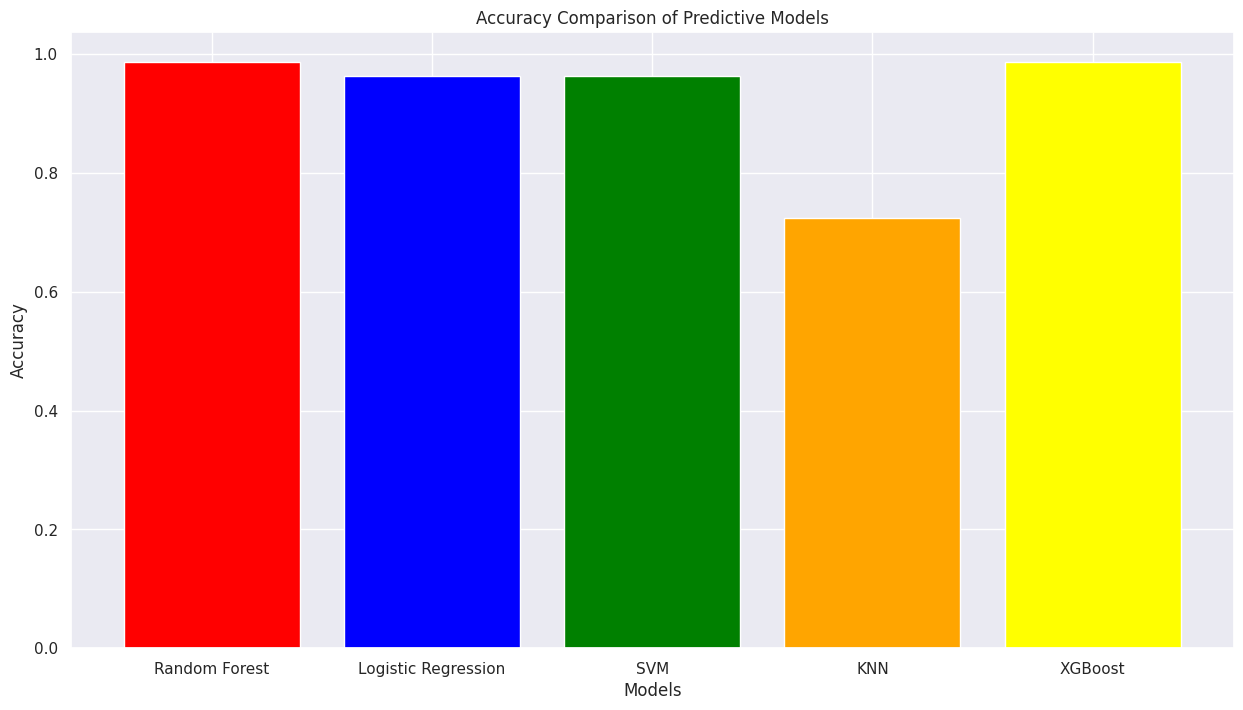

The best model is: Random Forest with an accuracy of 0.9875


In [75]:
models = ['Random Forest', 'Logistic Regression','SVM','KNN', 'XGBoost']
accuracies = [model2.score(X_test, y_test), model1.score(X_test, y_test), model3.score(X_test, y_test), model4.score(X_test, y_test), model5.score(X_test, y_test)]
sns.set(rc={'figure.figsize':(15,8)})
plt.bar(models, accuracies, color=['red', 'blue', 'green','orange','yellow'])
plt.title('Accuracy Comparison of Predictive Models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()
best_model = models[np.argmax(accuracies)]
print('The best model is:', best_model, 'with an accuracy of', np.max(accuracies))